## Tesseract -- combine datasets

Exploring individual datasets is very useful. However, the power of Geodesic is only fully realized when spatial datasets are combined, or layered, so that new knowledge can be generated. 

When overlaying multiple spatial datasets it can be challenging to properly align each dataset by time, space, and resolution. Tesseract makes this process relatively painless and layers the input data like a well-stacked deck of cards.

Below, Tesseract is used to layer the NASA Grace soild moisture data with the rainfall data inside of the project

In [2]:
import geodesic
print("geodesic version = ",geodesic.__version__)

geodesic version =  0.11.7


In [3]:
#Toggle between clusters
geodesic.config.ConfigManager().set_active_config('seerai')

In [4]:
geodesic.set_active_project('geodesic-example-1')

{'name': 'geodesic-example-1',
 'alias': 'geodesic_example_1',
 'description': 'an example project to demonstrategeodesic',
 'owner': 'auth0|62605f22b722a5006f32765b',
 'keywords': '',
 'uid': 'd0768e729eda9d133df3c7d7fbf131ae6ec780c3'}

In [5]:
ds = geodesic.list_datasets(project='geodesic-example-1')
print(ds)

{'ecmwf': dataset:*:*:*:ecmwf, 'grace-mass': dataset:*:*:*:grace-mass, 'naip-imagery': dataset:*:*:*:naip-imagery, 'geodesic-example-1-tesseract-job': dataset:*:dataset:*:geodesic-example-1-tesseract-job, 'geodesic-example-1-tesseract-job2': dataset:*:dataset:*:geodesic-example-1-tesseract-job2}


### Tesseract Job Specs

In [6]:
#Spec Tesseract job
from geodesic.tesseract import Job, AssetSpec, GlobalProperties, TemporalBinning
from datetime import datetime

bbox = [-101.837769,43.953282,-100.936890,44.754535]

job_spec = {
    'name': 'geodesic-example-1-tesseract-job2',
    'alias': 'geodesic example 1 Tesseract Job2',
    'description': 'A demo job to show how tesseract can combine USDA CDL and global precipation data',
    'bbox': bbox,
    'project': 'geodesic-example-1',
    'bbox_epsg': 4326,
    'output_epsg': 3857,
    'workers': 1,
    'asset_specs': [
        {
            'dataset': 'ecmwf',
            'name': 'ecmwf',
            'project': 'geodesic-example-1',
            'assets': ['total_precipitation'],
            'pixel_size': [500.0, 500.0],
            'resample': 'bilinear',
            'datetime': (datetime(2016,1,1), datetime(2018,7,1)),
            'temporal_binning': {
                'equal': {
                    'bin_size': '365D'
                }
            }
            },
        {
            'dataset': 'naip-imagery',
            'project': 'geodesic-example-1',
            'name': 'naip',
            'assets':['R','G', 'B'],
            'pixel_size': [500.0, 500.0],
            'resample': 'bilinear',
            'datetime': (datetime(2016,1,1), datetime(2018,7,1)),
            'temporal_binning': {
                'reference': 'ecmwf'
                }
        },
        
    ],
    'steps': [
    ]
}

In [7]:
#Assign job specs to variable
job = Job(**job_spec)

In [8]:
#Submit the job to Tesseract. Selecting dry_run=True returns returns the job attributes without actually running the job
example_run = job.submit(dry_run=False)

In [9]:
#View output dictionary
import pprint
pprint.pprint(example_run)

None


In [10]:
job.submit()

In [11]:
"""

View job status to verify that the job is completed. The number of quarks completed should match the number of quarks 
in the submitted job
"""
job.status()

{'job_id': '9cd0ffdc',
 'state': 'completed',
 'n_quarks': 6,
 'n_quarks_completed': 6}

### View job output

In [12]:
"""

Use Geodesic's zarr function to return the zarr group for the job output. 'Zarr is a format for the 
storage of chunked, compressed, N-dimensional arrays'. (https://gdal.org/drivers/raster/zarr.html)
"""
#View zarr file info
zf = job.zarr('ecmwf')
zf.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.FSStore
No. members,5
No. arrays,5
No. groups,0
Arrays,"bands, tesseract, times, x, y"


In [13]:
"""

From the zarr output we can call the tesseract array. Below, we can see that the shape of the array 
corresponds to the time bins (3), the asset count (1) and the array area (249 x 201). If we instead called returned the zarr
object for the 'naip-imagery' dataset the shape would be (3, 3, 249, 201) because that dataset was run through tesseract with 2
assets.
"""
import matplotlib.pyplot as plt
import numpy as np
tess = zf['tesseract']
tess.shape

(3, 1, 249, 201)

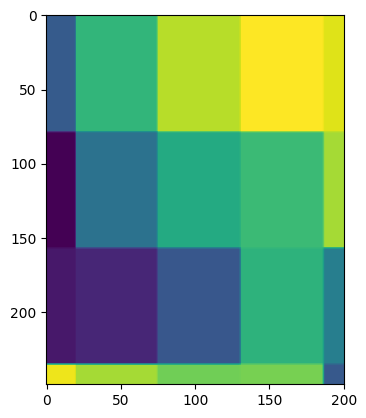

In [14]:
#View the output of the tesseract job
import numpy as np

#Calculate percent away from the mean for each pixel
data = 1-((tess)/np.mean(tess))

#Reshape result to plot
image = data[1,0,:, :]
plt.imshow(image)

### Write result to geotiff

In [56]:
#Get and make a variable out of a particular dataset
result = geodesic.get_dataset('geodesic-example-1-tesseract-job2', project='geodesic-example-1')

In [ ]:
#Assign the predipitation dataset to an array using Geodesic's warp function
result_ecmwf = result.warp(bbox=bbox, datetime=datetime, bbox_srs='EPSG:4326', output_srs='EPSG:3857',
    asset_names=['ecmwf'], pixel_size=(500.0, 500.0)
)

In [83]:
#Write array to geotiff-->shapefile
result_ecmwf = result.warp(bbox=bbox, bbox_srs='EPSG:4326', output_srs='EPSG:3857', pixel_size=(500,500), content_type='tiff', asset_names=['ecmwf'], as_numpy=False)

with open("example_result.tif", 'wb') as fp:
    fp.write(result_ecmwf)

### Connect datasets

In [ ]:
from geodesic.entanglement import Object

In [96]:
#Get datasets
ecmwf = geodesic.get_dataset('ecmwf')
naip = geodesic.get_dataset('naip-imagery')

In [88]:
#Make connections
ecmwf.connect_with(
    predicate={
        'name': 'links'
    },
    object=naip
)

dataset:*:*:*:ecmwf --links--> dataset:*:*:*:naip-imagery

In [89]:
#View Connections
conn = ecmwf.connections()
conn

[dataset:*:*:*:ecmwf --links--> dataset:*:*:*:naip-imagery]

In [92]:
#Plot connections
import networkx as nx
g = geodesic.get_objects(project='geodesic-example-1',as_graph=True)

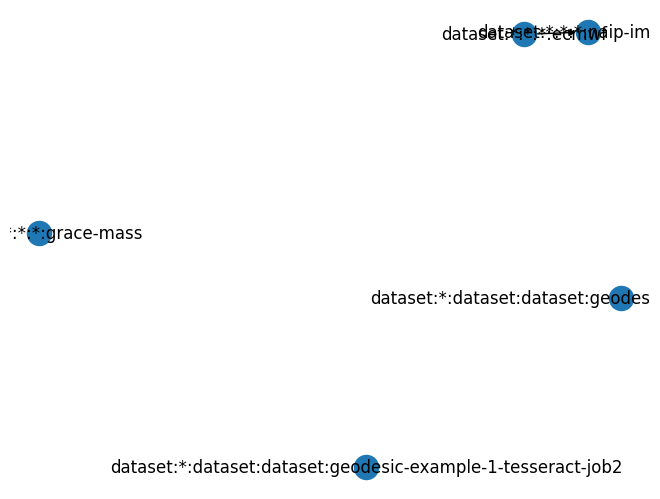

In [93]:
nx.draw(g, with_labels=True)